# Qubit with dephasing

We consider a qubit evolving according to the Hamiltonian

$$
H = \dfrac{\Omega}{2}\theta_y.
$$
Moreover we consider that the qubit is subject to dephasing along directions $\hat{e}_z$ with rate $\Gamma_z$ and along direction $\hat{e}_\varphi$ with rate $\Gamma_\varphi$.

The angle $\varphi$ is a parameter of the model.

The dynamical equations are:

$$
\dot{x} = -Γ_z x - Γ_φ~\cos(φ)(x \cos\varphi - z\sin\varphi) + \Omega~z \qquad (1)
$$

$$
\dot{z} = Γ_z~\sin\varphi(x \cos\varphi - z\sin\varphi) - \Omega x \qquad (2)
$$

The figure below illustrates the relation between the different components of the spin.

In [1]:
using LazySets, Plots, LaTeXStrings

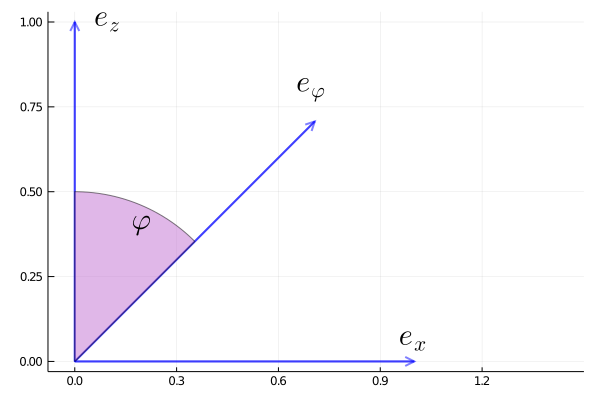

In [2]:
using Optim

ex = LineSegment([0, 0.], [1, 0.])
ez = LineSegment([0, 0.], [0, 1.])
eφ = LineSegment([0, 0.], [1, 1.]/sqrt(2))

fig = plot(ratio=1, xlims=(0.0, 1.5))

plot!(fig, ex, c=:blue, arrow=:arrow, lw=2.0, markersize=0)
plot!(annotations=(1.0, 0.06, text(L"e_x", 20)))

plot!(ez, c=:blue, lw=2.0, arrow=:arrow, markersize=0)
plot!(annotations=(0.1, 1.0, text(L"e_z", 20)))

plot!(eφ, c=:blue, lw=2.0, arrow=:arrow, markersize=0)
plot!(annotations=(0.7, 0.8, text(L"e_\varphi", 20)))

plot!(annotations=(0.2, 0.4, text(L"\varphi", 20)))

xpos = HalfSpace([-1.0, 0.0], 0.0) # x >= 0
ypos = HalfSpace([0.0, -1.0], 0.0) # y >= 0
q = HalfSpace([1.0, -1.0], 0.0) # y >= x
B = Ball2(zeros(2), 0.5) ∩ HPolytope([xpos, ypos, q])
B = overapproximate(B, PolarDirections(200));

plot!(fig, B)

The components of the spin in the Block sphere are $x = tr(\rho_t \theta_x)$ and $x = tr(\rho_t \theta_z)$ where $\rho_t$ is the density matrix of the system.

**Observation.** Equations (1-2) can be solved analytically.

We are interested in the generalization of the model where the dephasing rates $\Gamma_z$ and $\Gamma_\varphi$ are not known exactly, but only approximately.

- $\Gamma_z = \Gamma_z^0 \pm \Delta \Gamma_z$

- $\Gamma_\varphi = \Gamma_\varphi^0 \pm \Delta \Gamma_\varphi$

## Implementation

Since the system is linear we can use the algorithm `ASB07` which handles parameter variations and uses linear systems reachability.

However in this notebook we'll use `TMJets` directly which can also handle the case if we want to add nonlinearities to the system's equations. In this case, for each parameter we add a new state varaible with constant (zero) dynamics, and the parameter variation is encoded in the initial states. 

In [3]:
using ReachabilityAnalysis
const RA = ReachabilityAnalysis
using ReachabilityAnalysis: set

In [4]:
const φ = pi / 4
const Ω = 1.0

1.0

In [5]:
@taylorize function dephasing!(du, u, p, t)
    x, z, Γz, Γφ = u
    y = x*cos(φ) - z*sin(φ)
    du[1] = -Γz*x - Γφ*cos(φ)*y + Ω*z
    du[2] = Γφ*sin(φ)*y-Ω*x
    du[3] = zero(Γz)
    du[4] = zero(Γφ)
    return du
end

## Fixed dephasing rates

The initial condition is $x(0) = 1$, $z(0) = 0$ and the dephasing rates are assumed to be constant and equal to $\Gamma_z = 0.5$ and $\Gamma_\varphi = 0.8$ respectively.

In [6]:
U0_fixed = Hyperrectangle([1, 0, 0.5, 0.8], zeros(4))
prob = @ivp(u' = dephasing!(u), dim=4, u(0) ∈ U0_fixed)

# we shrink the initial abs_tol to increase the precision
@time sol = solve(prob, tspan=(0.0, 10.0), alg=TMJets(abs_tol=1.e-15))
solz = overapproximate(sol, Zonotope);
solz_fix =deepcopy(solz);

 17.481048 seconds (35.91 M allocations: 2.071 GiB, 3.95% gc time)


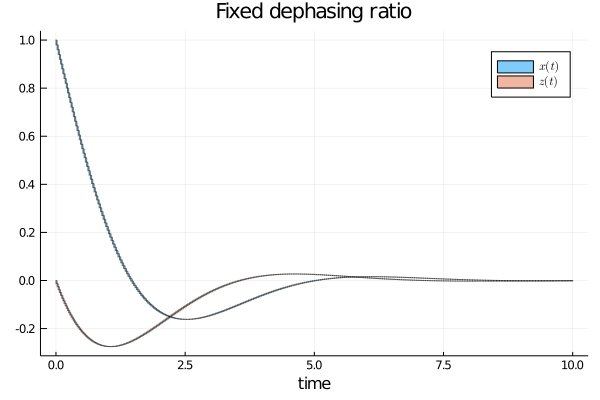

In [7]:
plot(solz, vars=(0, 1), xlab="time", lab=L"x(t)", title="Fixed dephasing ratio")
plot!(solz, vars=(0, 2), xlab="time", lab=L"z(t)")

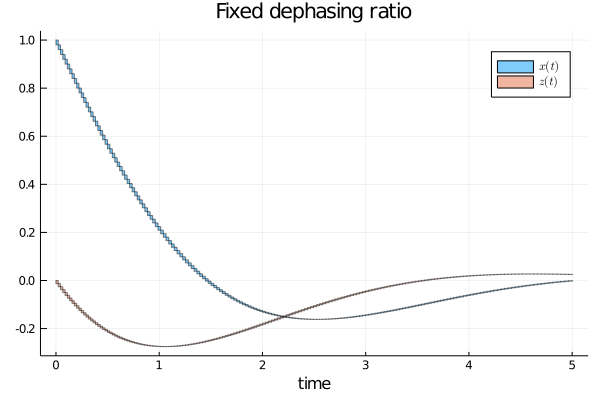

In [8]:
plot(solz(0 .. 5.0), vars=(0, 1), xlab="time", lab=L"x(t)", title="Fixed dephasing ratio")
plot!(solz(0 .. 5.0), vars=(0, 2), xlab="time", lab=L"z(t)")

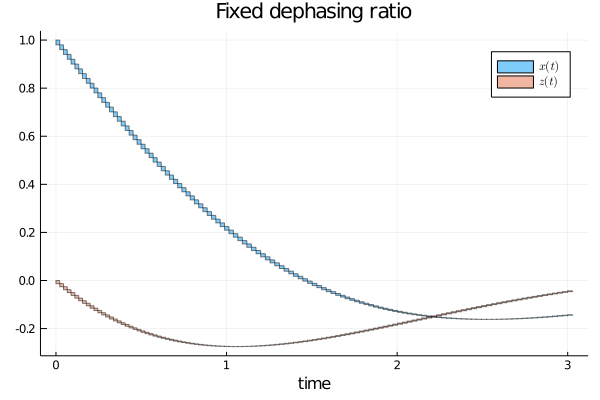

In [9]:
plot(solz(0 .. 3.0), vars=(0, 1), xlab="time", lab=L"x(t)", title="Fixed dephasing ratio")
plot!(solz(0 .. 3.0), vars=(0, 2), xlab="time", lab=L"z(t)")

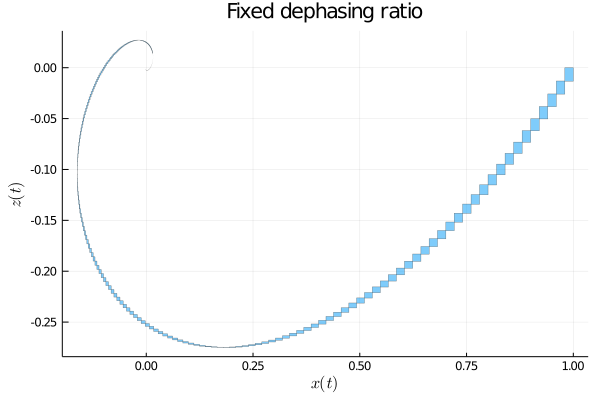

In [10]:
plot(solz, vars=(1, 2), xlab=L"x(t)", ylab=L"z(t)", lw=0.4, title="Fixed dephasing ratio")

Next we compute the rate of variation of $x(t)$ and the rate of varition of $z(t)$ using set-based computations.

The idea is to transform the zonotopic flowpipe directly without error by projecting onto the state variables $x-z$ and to obtain the rate of $x(t)$ and $z(t)$ according to the system's dynamics.

If we let $u' = [x, z, Γz, Γφ]' = Au$, then the matrix $A$ is:

In [11]:
Γz0 = overapproximate(project(solz[1], (3,)), Interval).X.dat
Γz = IntervalArithmetic.mid(Γz0)
@assert iszero(IntervalArithmetic.diam(Γz0))

Γφ0 = overapproximate(project(solz[1], (4,)), Interval).X.dat
Γφ = IntervalArithmetic.mid(Γφ0)
@assert iszero(IntervalArithmetic.diam(Γφ0))

A = [  -Γz-Γφ*cos(φ)^2     Γφ*cos(φ)*sin(φ)+Ω  0  0;
     Γφ*sin(φ)*cos(φ)-Ω       -Γφ*sin(φ)^2     0  0]

2×4 Array{Float64,2}:
 -0.9   1.4  0.0  0.0
 -0.6  -0.4  0.0  0.0

We compute the maximum values of $x'(t)$ and $z'(t)$ using support functions on the flowpipe.

In [12]:
solz_fix_vel = linear_map(A, solz_fix)

@show maxvx = ρ([1., 0.], solz_fix_vel);
@show maxvz = ρ([0., 1.], solz_fix_vel);

maxvx = ρ([1.0, 0.0], solz_fix_vel) = 0.09135634060252744
maxvz = ρ([0.0, 1.0], solz_fix_vel) = 0.152841561822016


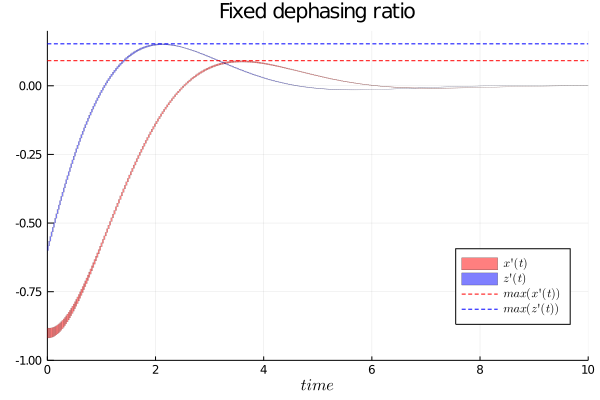

In [13]:
plot(xlab=L"time", title="Fixed dephasing ratio")
plot!(solz_fix_vel, vars=(0,1), color=:red, lw=0.2, alpha=0.5, lab=L"x'(t)")
plot!(solz_fix_vel, vars=(0,2), color=:blue, lw=0.2, alpha=0.5, lab=L"z'(t)")

plot!(x -> maxvx, color=:red, xlims=(0.0, 10.0), ylims=(-1.0, 0.2), style=:dash, legend=:bottomright, lab=L"max(x'(t))")
plot!(x -> maxvz, color=:blue, xlims=(0.0, 10.0), style=:dash, legend=:bottomright, lab=L"max(z'(t))")

## Uncertain dephasing rates

The initial condition is $x(0) = 1$, $z(0) = 0$ and the dephasing rates are assumed to be constant and equal to $\Gamma_z = 0.5 \pm 0.2$ and $\Gamma_\varphi = 0.8 \pm 0.2$ respectively.

In [14]:
U0_fixed = Hyperrectangle([1, 0, 0.5, 0.8], [0, 0, 0.2, 0.2])
prob = @ivp(u' = dephasing!(u), dim=4, u(0) ∈ U0_fixed)

@time sol = solve(prob, tspan=(0.0, 10.0), alg=TMJets(abs_tol=1.e-15))
solz = overapproximate(sol, Zonotope);
solz_unc = deepcopy(solz);

  0.759529 seconds (8.31 M allocations: 730.983 MiB, 21.09% gc time)


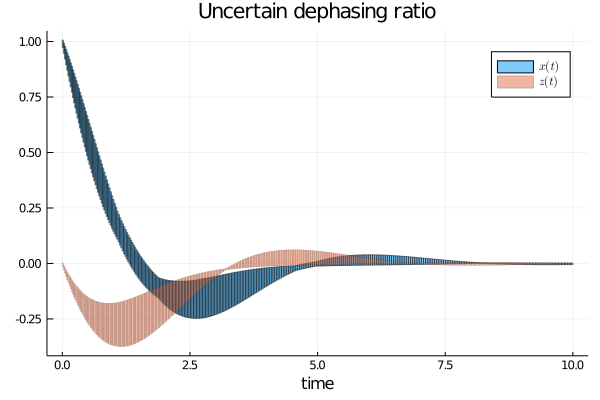

In [15]:
plot(solz, vars=(0, 1), xlab="time", lab=L"x(t)", title="Uncertain dephasing ratio")
plot!(solz, vars=(0, 2), xlab="time", lab=L"z(t)", lw=0.2)

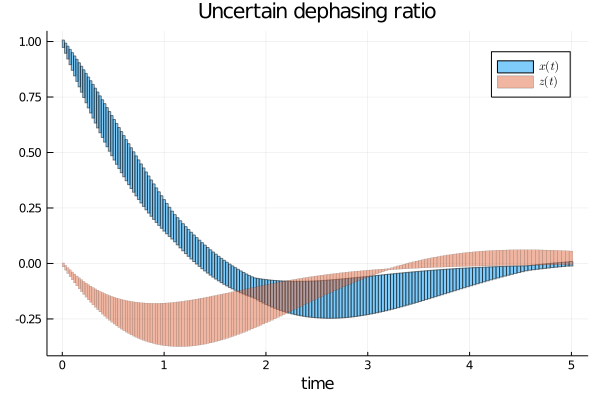

In [16]:
plot(solz(0 .. 5.0), vars=(0, 1), xlab="time", lab=L"x(t)", title="Uncertain dephasing ratio")
plot!(solz(0 .. 5.0), vars=(0, 2), xlab="time", lab=L"z(t)", lw=0.2)

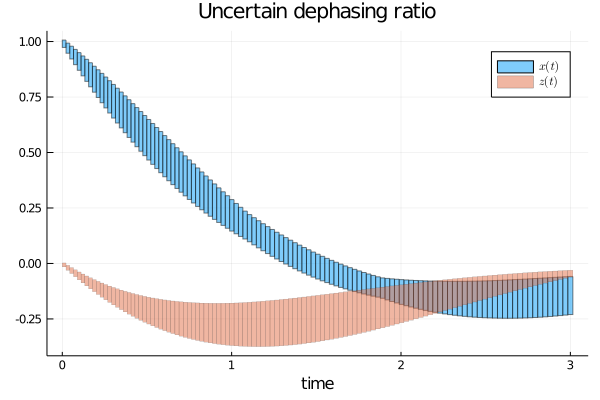

In [17]:
plot(solz(0 .. 3.0), vars=(0, 1), xlab="time", lab=L"x(t)", title="Uncertain dephasing ratio")
plot!(solz(0 .. 3.0), vars=(0, 2), xlab="time", lab=L"z(t)", lw=0.2)

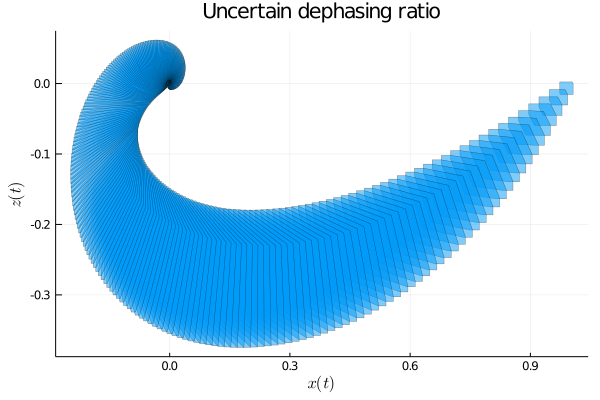

In [18]:
plot(solz, vars=(1, 2), xlab=L"x(t)", ylab=L"z(t)", lw=0.4, title="Uncertain dephasing ratio")

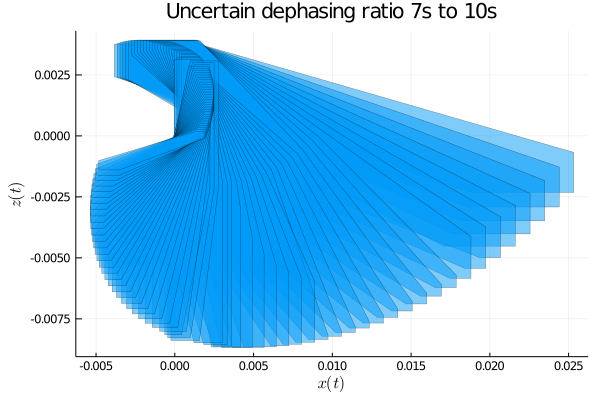

In [19]:
plot(solz(7.0 .. 10), vars=(1, 2), xlab=L"x(t)", ylab=L"z(t)", lw=0.4, title="Uncertain dephasing ratio 7s to 10s")

Next we compute the rate of variation of $x(t)$ and the rate of varition of $z(t)$ using set-based computations.

The idea is to transform the zonotopic flowpipe by ovearpproximating the linear map with an interval matrix.

If we let $u' = [x, z, Γz, Γφ]' = \tilde{A} u$, then the matrix $\tilde{A}$ is an *interval matrix* such that:

In [20]:
Γz = overapproximate(project(solz[1], (3,)), Interval).X.dat

Γφ = overapproximate(project(solz[1], (4,)), Interval).X.dat

# in this case the diameters of Γz and of Γφ are not zero
Ã = [  -Γz-Γφ*cos(φ)^2     Γφ*cos(φ)*sin(φ)+Ω     0  0;
        Γφ*sin(φ)*cos(φ)-Ω       -Γφ*sin(φ)^2     0  0] |> IntervalMatrix

2×4 IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}:
 [-1.20001, -0.6]    [1.29999, 1.5]    [0, 0]  [0, 0]
 [-0.700001, -0.5]  [-0.5, -0.299999]  [0, 0]  [0, 0]

In this case we overapproximate the linear map of the interval matrix of a zonotope with a zonotope. The algorithm may add overapproximation error.

In [21]:
solz_unc_vel = [ReachSet(overapproximate(Ã * set(R), Zonotope), tspan(R)) for R in solz_unc] |> Flowpipe;

We compute the maximum values of $x'(t)$ and $z'(t)$ using support functions on the flowpipe.

In [22]:
solz_unc_vel = linear_map(A, solz_unc)

@show maxvx = ρ([1., 0.], solz_unc_vel);
@show maxvz = ρ([0., 1.], solz_unc_vel);

maxvx = ρ([1.0, 0.0], solz_unc_vel) = 0.17515842869461762
maxvz = ρ([0.0, 1.0], solz_unc_vel) = 0.2218432056714787


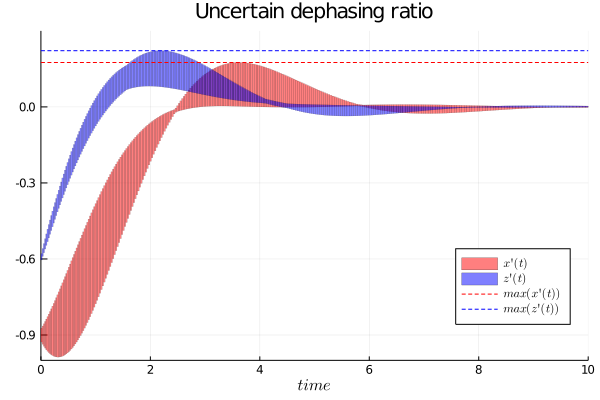

In [23]:
plot(xlab=L"time", title="Uncertain dephasing ratio")
plot!(solz_unc_vel, vars=(0,1), color=:red, lw=0.2, alpha=0.5, lab=L"x'(t)")
plot!(solz_unc_vel, vars=(0,2), color=:blue, lw=0.2, alpha=0.5, lab=L"z'(t)")

plot!(x -> maxvx, color=:red, xlims=(0.0, 10.0), ylims=(-1.0, 0.3), style=:dash, legend=:bottomright, lab=L"max(x'(t))")
plot!(x -> maxvz, color=:blue, xlims=(0.0, 10.0), style=:dash, legend=:bottomright, lab=L"max(z'(t))")

## Comparison between fixed and uncertain parameters

Below we compare the rate of variation of $x'(t)$ and $z'(t)$ for the case with fixed dephasing ratio and uncertain dephasing ratio respectively.

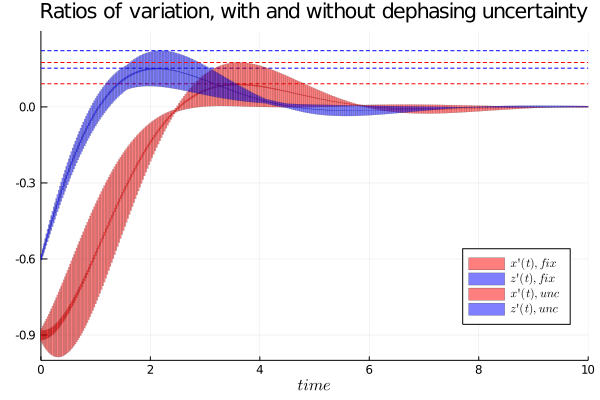

In [24]:
plot(xlab=L"time", title="Ratios of variation, with and without dephasing uncertainty")

plot!(solz_fix_vel, vars=(0,1), color=:red, lw=0.2, alpha=0.5, lab=L"x'(t), fix")
plot!(solz_fix_vel, vars=(0,2), color=:blue, lw=0.2, alpha=0.5, lab=L"z'(t), fix")
maxvx = ρ([1., 0.], solz_fix_vel);
maxvz = ρ([0., 1.], solz_fix_vel);
plot!(x -> maxvx, color=:red, xlims=(0.0, 10.0), ylims=(-1.0, 0.2), style=:dash, legend=:bottomright, lab="")
plot!(x -> maxvz, color=:blue, xlims=(0.0, 10.0), style=:dash, legend=:bottomright, lab="")

plot!(solz_unc_vel, vars=(0,1), color=:red, lw=0.2, alpha=0.5, lab=L"x'(t), unc")
plot!(solz_unc_vel, vars=(0,2), color=:blue, lw=0.2, alpha=0.5, lab=L"z'(t), unc")
maxvx = ρ([1., 0.], solz_unc_vel);
maxvz = ρ([0., 1.], solz_unc_vel);
plot!(x -> maxvx, color=:red, xlims=(0.0, 10.0), ylims=(-1.0, 0.3), style=:dash, legend=:bottomright, lab="")
plot!(x -> maxvz, color=:blue, xlims=(0.0, 10.0), style=:dash, legend=:bottomright, lab="")